In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
import random
from gurobipy import GRB, quicksum

In [62]:
def SetQ(d,s):
    '''
    Setup the global Q for quadratic oracle, so we don't have to re-create Q every query
    Run this function before we run any function call that makes QuadraticOracle queries
    May 25th 2020
    '''
    global Q
    Diagonal = np.zeros(d)
    for i in range(0,s):
        p = 0.5
        #Diagonal[i]= (i+1)**(-1.0/p)
        Diagonal[i] = 1
    Q = np.diag(Diagonal)

In [63]:
def object_fcn(x):
    return np.dot(np.dot(x.T,Q),x)

In [64]:
def QuadraticOracle(x,y,kappa,mu,delta_0,d,s):
    '''Implements comparison oracle for sparse quadratic
    In noiseless case, return 1 if f(x)<f(y); otherwise return -1
    function f(x) = x^TQx
    May 25th 2020'''
    #Diagonal = np.concatenate((np.ones(s),np.zeros(d-s)))
    #Q = np.diag(Diagonal)
    #fx = np.dot(np.dot(x.T,Q),x)
    #fy = np.dot(np.dot(y.T,Q),y)
    fx = object_fcn(x)
    fy = object_fcn(y)
    f_diff = np.squeeze(fy - fx)
    if f_diff == 0:
        f_diff = (random.randrange(2) - 0.5)/50
    prob = 0.5 +np.minimum(mu*np.absolute(f_diff)**(kappa-1.0),delta_0) # Probability of bit-flip
    mask = 2*np.random.binomial(1,prob) - 1
    res = np.squeeze(mask*np.sign(f_diff))
    if mask == 1:
        bit_flipped = 0
    else:
        bit_flipped = 1
    return res, bit_flipped
    
    

In [65]:
## Testing Quadratic Oracle
s = 5
d = 20
kappa = 2.0
mu = 0.5 
delta_0 = 0.2
x = np.random.randn(20,1)
y = np.random.randn(20,1)
f_diff = -3.5

SetQ(d,s)
Query_result, bit_flipped = QuadraticOracle(x,y,kappa,mu,delta_0,d,s)
print(QuadraticOracle(x,y,kappa,mu,delta_0,d,s)[0])
print(Query_result, bit_flipped)

1.0
1.0 0


## Notes on Optimization Package

The function below solves the problem:

$ \text{minimize}_{x\in\mathbb{R}^{d}} \sum_{i=1}^{d}y_iz_{i}^{\top}x \quad \text{ subject to: } \|x\|_2 \leq 1 \text{ and } \|x\|_1 \leq \sqrt{s} $

I've implemented it using Gurobi, but one can use any package.

In [66]:
def Solve1BitCS(y,Z,m,d,s):
    '''This function creates a quadratic programming model, calls Gurobi
    and solves the 1 bit CS subproblem. This function can be replaced with
    any suitable function that calls a convex optimization package.
    =========== INPUTS ==============
    y ........... length d vector of one-bit measurements
    Z ........... m-by-d sensing matrix
    m ........... number of measurements
    d ........... dimension of problem
    s ........... sparsity level
    
    =========== OUTPUTS =============
    x_hat ....... Solution. Note that \|x_hat\|_2 = 1
    '''
    
    model = gp.Model("1BitRecovery")
    x = model.addVars(2*d, vtype = GRB.CONTINUOUS)
    c1 = np.dot(y.T,Z)
    c = list(np.concatenate((c1,-c1)))

    model.setObjective(quicksum(c[i]*x[i] for i in range(0,2*d)), GRB.MAXIMIZE)
    model.addConstr(quicksum(x) <= np.sqrt(s),"ell_1")  # sum_i x_i <=1
    model.addConstr(quicksum(x[i]*x[i] for i in range(0,2*d)) - 2*quicksum(x[i]*x[d+i] for i in range(0,d))<= 1, "ell_2") # sum_i x_i^2 <= 1
    model.addConstrs(x[i] >= 0 for i in range(0,2*d))
    model.Params.OUTPUTFLAG = 0

    model.optimize()
    TempSol = model.getAttr('x')
    x_hat = np.array(TempSol[0:d] - np.array(TempSol[d:2*d]))
    return x_hat

In [67]:
## Testing Solving1BitCS
m = 200
d = 500
s = 100
Z = np.zeros((m,d))
for i in range(0,m):
    temp = np.random.randn(1,d)
    Z[i,:] = temp/np.linalg.norm(temp)
    
xsol = np.concatenate((np.ones(s),np.zeros(d-s)))
y = np.squeeze(np.sign(np.dot(Z,xsol)).T)

x_hat = Solve1BitCS(y,Z,m,d,s)

Error = np.linalg.norm(x_hat - xsol/np.linalg.norm(xsol))
print(Error)
angle = np.arccos(np.dot(x_hat,xsol/np.linalg.norm(xsol)))*(180/np.pi)
print(angle)
# You'll notice that the error is quite large. This is to be expected.
# One can check that the supports are the same.

1.120218394534199
68.12670369606094


In [101]:
def GradientEstimator(x_in,Z,r,kappa,delta_0,mu,m,d,s):
    '''This function estimates the gradient vector from m Comparison
    oracle queries, using 1 bit compressed sensing and Gurobi
    ================ INPUTS ======================
    Z ......... An m-by-d matrix with rows z_i uniformly sampled from unit sphere
    x_in ................. Any point in R^d
    r ................ Sampling radius.
    kappa,delta_0, mu..... Comparison oracle parameters.
    m ..................... number of measurements.
    d ..................... dimension of problem
    s ..................... sparsity
    
    ================ OUTPUTS ======================
    g_hat ........ approximation to g/||g||
    tau .......... fraction of bit-flips/ incorrect one-bit measurements.
    y ............ vector of measurements
    
    23rd May 2020
    '''
    y = np.zeros(m)
    tau = 0
    for i in range(0,m):
        x_temp = Z[i,:]
        y[i], bit_flipped = QuadraticOracle(x_in,x_in + r*Z[i,:],kappa,mu,delta_0,d,s)
        tau += bit_flipped
    g_hat = Solve1BitCS(y,Z,m,d,s)
    tau = tau/m
    return g_hat,tau,y

In [102]:
def TestSparsity(y,g_hat,Z,s,m):
    '''
    This function tests agreement between the measurements, y, and the estimated 
    gradient, g_hat. If the agreement is not good enough, it increases s and m.
    
    '''
    y_hat = np.sign(np.dot(Z,g_hat))
    HammingFraction = len([i for i in range(m) if y[i] != y_hat[i]])/m
    if HammingFraction >= 0.45:
        print("Fail!")
    return HammingFraction

In [127]:
## Testing GradientEstimator
m = 20
d = 800
s_true = 50
s_est = 50
r = 0.5/np.sqrt(s_est)
#r = 0.001
delta_0 = 0.1
kappa = 2

Z = np.zeros((m,d))
for i in range(0,m):
    temp = np.random.randn(1,d)
    Z[i,:] = temp/np.linalg.norm(temp)
    
x_in = np.squeeze(10*np.random.randn(d,1) + 100*np.ones((d,1)))

SetQ(d,s_true)
g_hat,tau,y = GradientEstimator(x_in,Z,r,kappa,delta_0,mu,m,d,s_est)
HammingFraction = TestSparsity(y,g_hat,Z,s_est,m)
print(HammingFraction)
#Diagonal = np.concatenate((np.ones(s),np.zeros(d-s)))
#Q = np.diag(Diagonal)
g_true = 2*np.dot(Q,x_in)
error = np.linalg.norm(g_hat - g_true/np.linalg.norm(g_true))
print(error)
print(tau)

0.0
1.4295667048714789
0.3


In [70]:
def GetStepSize(x,g_hat,last_step_size,default_step_size,kappa,mu,delta_0,d,s,warm_started):
    '''This function use line search to estimate the best step size on the given 
    direction via noisy comparison 
    ================ INPUTS ======================
    x ........................ current point
    g_hat .................... search direction
    last_step_size ........... step size from last itertion
    default_step_size......... a safe lower bound of step size
    kappa,delta_0, mu......... Comparison oracle parameters.
    d ........................ dimension of problem
    s ........................ sparsity
    
    ================ OUTPUTS ======================
    alpha .................... step size found
    less_than_defalut ........ return True if found step size less than default step size
    queries_count ............ number of oracle queries used in linesearch
    25th May 2020
    '''
    
    # First make sure current step size descends
    omega = 0.05
    num_round = 40
    descend_count = 0
    queries_count = 0
    less_than_defalut = False
    #update_factor = np.sqrt(2)
    update_factor = 2
    
    if warm_started:
        alpha = last_step_size  # start with last step size
    else:
        alpha = default_step_size
    point1 = x - alpha * g_hat
    
    for round in range(0,num_round): # compare n rounds for every pair of points, 
        is_descend,bit_flipped = QuadraticOracle(point1,x,kappa,mu,delta_0,d,s)
        queries_count = queries_count + 1
        if is_descend == 1:
            descend_count = descend_count + 1
    p = descend_count/num_round
    # print(p)
    
    
    # we try increase step size if p is larger, try decrease step size is
    # smaller, otherwise keep the current alpha
    if p >= 0.5 + omega:   # compare with x
        while True:        
            point2 = x - update_factor * alpha * g_hat
            descend_count = 0
            for round in range(0,num_round):   # compare n rounds for every pair of points,
                is_descend,bit_flipped = QuadraticOracle(point2,point1,kappa,mu,delta_0,d,s)   # comapre with point1
                queries_count = queries_count + 1
                if is_descend == 1:
                    descend_count = descend_count + 1
            p = descend_count/num_round
            if p >= 0.5 + omega:
                alpha = update_factor * alpha
                point1 = x - alpha * g_hat
            else:
                return alpha,less_than_defalut,queries_count
    elif warm_started == False:
        less_than_defalut = True
        return alpha,less_than_defalut,queries_count
    elif p <= 0.5 - omega:   # else: we try decrease step size
        while True:
            alpha = alpha / update_factor
            if alpha < default_step_size:
                alpha = default_step_size
                less_than_defalut = True
                return alpha,less_than_defalut,queries_count
            point2 = x - alpha * g_hat
            descend_count = 0
            for round in range(0,num_round): 
                is_descend,bit_flipped = QuadraticOracle(point2,x,kappa,mu,delta_0,d,s)   # compare with x
                queries_count = queries_count + 1
                if is_descend == 1:
                    descend_count = descend_count + 1
            p = descend_count/num_round
            if p >= 0.5 + omega:
                return alpha,less_than_defalut,queries_count
    #else:
    #    alpha = last_step_size

    return alpha,less_than_defalut,queries_count

In [130]:
def SCOBO(num_iterations,default_step_size,x0,r,kappa,delta_0,mu,m,d,s,line_search,warm_started):
    ''' This function implements the SCOBO algorithm, as described 
    in our paper. 
    
    =============== INPUTS ================
    num_iterations ................ number of iterations
    default_step_size ............. default step size
    x0 ............................ initial iterate
    r ............................. sampling radius
    kappa, delta_0,mu ............. oracle parameters
    m ............................. number of samples per iteration
    d ............................. dimension of problem
    s ............................. sparsity level
    line_search ................... wheather linesearch for step size. if not, use default step size
    warm_started .................. wheather use warm start in linesearch
     
    =============== OUTPUTS ================
    regret ....................... vector of errors f(x_k) - min f
    tau_vec ...................... tau_vec(k) = fraction of flipped measurements at k-th iteration
    c_num_queries ................ cumulative number of queries.
    
    May 25th 2020
    '''
    regret = np.zeros((num_iterations,1))
    tau_vec = np.zeros((num_iterations,1))
    linesearch_queries = np.zeros(num_iterations)
    x = np.squeeze(x0)
    
    # NB, the following piece of code is a bit sloppy!
    # It essentially defines the objective function, so 
    # that we can evaluate the objective error of our current
    # solution. This should ultimately be replaced.
    
    # Diagonal = np.concatenate((np.ones(s),np.zeros(d-s)))
    # Q = np.diag(Diagonal)
    
    Z = np.zeros((m,d))
    for i in range(0,m):
        temp = np.random.randn(1,d)
        Z[i,:] = temp/np.linalg.norm(temp)
    
    # start with default step size when using line search
    step_size = default_step_size
    
    if linesearch:
        less_than_defalut_vec = np.zeros((num_iterations,1))  # not outputing this in current version
    
    for i in range(0,num_iterations):
        g_hat,tau, y = GradientEstimator(x,Z,r,kappa,delta_0,mu,m,d,s)
        HammingFraction = TestSparsity(y,g_hat,Z,s,m)
        print(["The Hamming Fraction is " + str(HammingFraction)])
        if linesearch:
            step_size,less_than_defalut,queries_count = GetStepSize(x,g_hat,step_size,default_step_size,kappa,mu,delta_0,d,s,warm_started)
            less_than_defalut_vec[i] = less_than_defalut
            linesearch_queries[i] = queries_count
            # print(queries_count)
        #print(step_size)
        x = x - step_size * g_hat
        regret[i] = object_fcn(x) # f(x_min) = 0
        print(regret[i])
        tau_vec[i] = tau
        
    c_num_queries = m*np.arange(start=0,stop = num_iterations,step = 1) + np.cumsum(linesearch_queries)
    #x_hat = x
    return x, regret,tau_vec,c_num_queries

In [131]:
m*np.arange(start=0,stop = 10,step = 1)
np.cumsum(np.ones(10))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [132]:
def Jamieson(num_iterations,default_step_size,x0,kappa,delta_0,mu,d,eta):
    ''' This function implements the SCOBO algorithm, as described 
    in our paper. 
    
    =============== INPUTS ================
    num_iterations ................ number of iterations
    default_step_size ............. default step size 
    x0 ............................ initial iterate
    kappa, delta_0,mu ............. oracle parameters
    d ............................. dimension of problem
    eta ........................... linear search tol
    
     
    =============== OUTPUTS ================
    regret ....................... vector of errors f(x_k) - min f
    tau_vec ...................... tau_vec(k) = fraction of flipped measurements at k-th iteration
    c_num_queries ................ cumulative number of queries.
    
    May 25th 2020
    '''
    
    regret = np.zeros((num_iterations,1))
    c_num_queries = np.zeros((num_iterations,1))
    #tau_vec = np.zeros((num_iterations,1))
    linesearch_queries = np.zeros(num_iterations)
    x = np.squeeze(x0)
    
    s = -999   # not using
    
    
    for i in range(0,num_iterations):
        # start with default step size when using line search
        #default_step_size = 1
        step_size_plus = default_step_size
        step_size_minus = -default_step_size
        queries_count = 0
        ## randomly select a direction
        cur_idx = random.randrange(d)
        #print(cur_idx)
        
        ## line search on this direction
        temp_pt_plus = np.copy(x)
        temp_pt_minus = np.copy(x)
        temp_pt_avg = np.copy(x)
        temp_pt_plus[cur_idx] = x[cur_idx] + step_size_plus
        temp_pt_minus[cur_idx] = x[cur_idx] + step_size_minus
        
        
        #print(type(x))
        
        #print(object_fcn(x))
        #print(temp_pt_plus)
        #print(temp_pt_minus)
        
        
        #print(QuadraticOracle(x,temp_pt_plus,kappa,mu,delta_0,d,s)[0])
        #print(QuadraticOracle(x,temp_pt_minus,kappa,mu,delta_0,d,s)[0])
        queries_count = queries_count + 1
        if QuadraticOracle(x,temp_pt_plus,kappa,mu,delta_0,d,s)[0]>0 and QuadraticOracle(x,temp_pt_minus,kappa,mu,delta_0,d,s)[0]<0:
            step_size_plus = 0
            temp_pt_plus[cur_idx] = x[cur_idx] + step_size_plus
            #print("step 1")
        
        queries_count = queries_count + 1
        if QuadraticOracle(x,temp_pt_plus,kappa,mu,delta_0,d,s)[0]<0 and QuadraticOracle(x,temp_pt_minus,kappa,mu,delta_0,d,s)[0]>0:
            step_size_minus = 0
            temp_pt_minus[cur_idx] = x[cur_idx] + step_size_minus
            #print("step 2")
        
        queries_count = queries_count + 1
        while QuadraticOracle(x,temp_pt_plus,kappa,mu,delta_0,d,s)[0] < 0:
            step_size_plus = 2 * step_size_plus
            temp_pt_plus[cur_idx] = x[cur_idx] + step_size_plus
            queries_count = queries_count + 1
            #print("step 3")
        
        queries_count = queries_count + 1
        while QuadraticOracle(x,temp_pt_minus,kappa,mu,delta_0,d,s)[0] < 0:
            step_size_minus = 2 * step_size_minus
            temp_pt_minus[cur_idx] = x[cur_idx] + step_size_minus
            queries_count = queries_count + 1
            #print("step 4")
        
        step_size_avg = (step_size_plus + step_size_minus) / 2
        
        while abs(step_size_plus - step_size_minus) >= eta / 2:
            temp_pt_avg[cur_idx] = x[cur_idx] + step_size_avg
            temp_pt_plus[cur_idx] = x[cur_idx] + (step_size_avg + step_size_plus) / 2
            temp_pt_minus[cur_idx] = x[cur_idx] + (step_size_avg + step_size_minus) / 2
            
            queries_count = queries_count + 1
            if QuadraticOracle(temp_pt_avg,temp_pt_plus,kappa,mu,delta_0,d,s)[0]<0:
                step_size_minus = step_size_avg
                step_size_avg = (step_size_avg + step_size_plus) / 2
            elif QuadraticOracle(temp_pt_avg,temp_pt_minus,kappa,mu,delta_0,d,s)[0]<0:
                step_size_plus = step_size_avg
                step_size_avg = (step_size_avg + step_size_minus) / 2
                queries_count = queries_count + 1
            else:
                step_size_plus = (step_size_avg + step_size_plus) / 2
                step_size_minus = (step_size_avg + step_size_minus) / 2
                queries_count = queries_count + 1
            #print("step 5")
        
        
        ## end of line search
        ## "gradient decent"
        x[cur_idx] = x[cur_idx] + step_size_avg
        
        
        regret[i] = object_fcn(x) # f(x_min) = 0
        c_num_queries[i] = queries_count
        #tau_vec[i] = tau
        print(regret[i])
        print(step_size_avg)
        
        
    c_num_queries = np.cumsum(c_num_queries)
    #x_hat = x
    return x, regret, c_num_queries

In [146]:
# Oracle parameters
kappa = 1.5
mu = 2
delta_0 = 0.5

# Dimension and sampling parameters
d = 500
s = 5
print(m)


# Gradient Descent Parameters
default_step_size = 1  #10
x0 = 100*np.ones((d,1))
num_iterations = 20

#r = default_step_size/np.sqrt(2)
L = 1
r = default_step_size/(2*np.sqrt(s))  

SetQ(d,s)

#linesearch = False
#warm_started = False
#x_hat, regret,tau_vec,c_num_queries = SCOBO(num_iterations,default_step_size,x0,r,kappa,delta_0,mu,m,d,s,linesearch,warm_started)

#linesearch = True
#warm_started = False
#x_hat_linesearch, regret_linesearch,tau_vec_linesearch,c_num_queries_linesearch = SCOBO(num_iterations,default_step_size,x0,r,kappa,delta_0,mu,m,d,s,linesearch,warm_started)

s_est = 1
m = int((s_est**2)*np.log(2*d/s_est))
linesearch = True
warm_started = True
x_hat_warm_started, regret_warm_started,tau_vec_warm_started,c_num_queries_warm_started = SCOBO(num_iterations,default_step_size,x0,r,kappa,delta_0,mu,m,d,s_est,linesearch,warm_started)


eta = 1
num_iterations = 100*num_iterations
x_jamieson, regret_jamieson, c_num_queries_jamieson = Jamieson(num_iterations,default_step_size,x0,kappa,delta_0,mu,d,eta)


6
['The Hamming Fraction is 0.16666666666666666']
[49999.99999994]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999987]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999981]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999974]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999968]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999961]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999955]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999948]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999942]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999935]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999929]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999922]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999916]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999909]
['The Hamming Fraction is 0.16666666666666666']
[49999.99999903]
['The Hamming Fraction 

[10000.015625]
0.125
[10000.015625]
1.625
[10000.015625]
-4.1796875
[10000.015625]
-0.375
[10000.015625]
-1.125
[10000.015625]
-0.125
[10000.015625]
-0.25
[10000.015625]
1.4375
[10000.015625]
-0.125
[10000.015625]
0.875
[10000.015625]
-0.375
[10000.015625]
-0.625
[10000.015625]
0.0
[10000.015625]
5.03125
[10000.015625]
-0.625
[10000.015625]
0.375
[10000.015625]
-0.625
[10000.015625]
0.375
[10000.015625]
-11.01953125
[10000.015625]
-22.501953125
[10000.015625]
0.625
[10000.015625]
1.8125
[10000.015625]
1.0625
[10000.015625]
-33.375
[10000.015625]
0.875
[10000.015625]
-0.625
[10000.015625]
0.0625
[10000.015625]
0.625
[10000.015625]
1.125
[10000.015625]
-1.125
[10000.015625]
-0.25
[10000.015625]
2.28125
[10000.015625]
0.0
[10000.015625]
0.875
[10000.015625]
-2.53125
[10000.015625]
0.84375
[10000.015625]
0.875
[10000.015625]
-0.125
[10000.015625]
-0.125
[10000.015625]
27.23046875
[10000.015625]
-0.6875
[10000.015625]
0.0
[10000.015625]
0.4375
[10000.015625]
5.875
[10000.015625]
-0.125
[100

[0.03125]
-3.8125
[0.03125]
0.0625
[0.03125]
3.78125
[0.03125]
5.96875
[0.03125]
0.75
[0.03125]
-0.375
[0.03125]
-0.25
[0.03125]
-0.25
[0.03125]
0.875
[0.03125]
0.875
[0.03125]
2.375
[0.03125]
1.625
[0.03125]
0.625
[0.03125]
1.25
[0.03125]
0.25
[0.03125]
-3.375
[0.03125]
1.953125
[0.03125]
-5.046875
[0.03125]
0.375
[0.03125]
-0.625
[0.03125]
1.8125
[0.03125]
0.625
[0.03125]
-1.96875
[0.03125]
21.875
[0.03125]
-1.875
[0.03125]
-0.375
[0.03125]
3.375
[0.03125]
0.375
[0.03125]
-0.125
[0.03125]
1.625
[0.03125]
-0.25
[0.03125]
-3.078125
[0.03125]
-1.875
[0.03125]
0.125
[0.03125]
0.875
[0.03125]
0.125
[0.03125]
-43.125
[0.03125]
1.25
[0.03125]
-0.71875
[0.03125]
0.0625
[0.03125]
7.859375
[0.03125]
-0.71875
[0.03125]
-0.828125
[0.03125]
0.8125
[0.03125]
1.03125
[0.03125]
2.25
[0.03125]
-2.625
[0.03125]
0.3125
[0.03125]
1.96875
[0.03125]
0.625
[0.03125]
-0.125
[0.03125]
0.0
[0.03125]
1.875
[0.03125]
0.0
[0.03125]
0.6875
[0.03125]
0.578125
[0.03125]
-0.125
[0.03125]
-0.625
[0.03125]
0.625
[0.03

[0.03125]
2.234375
[0.03125]
0.625
[0.03125]
5.7734375
[0.03125]
2.28125
[0.03125]
0.625
[0.03125]
-1.671875
[0.03125]
0.6875
[0.03125]
-7.5625
[0.03125]
-1.75
[0.03125]
0.875
[0.03125]
-1.375
[0.03125]
-0.625
[0.03125]
0.875
[0.03125]
-1.4375
[0.03125]
0.875
[0.03125]
0.625
[0.03125]
0.875
[0.03125]
14.625
[0.03125]
-0.125
[0.03125]
1.875
[0.03125]
1.8125
[0.03125]
-0.09375
[0.03125]
-0.25
[0.03125]
-2.625
[0.03125]
-0.5
[0.03125]
0.375
[0.03125]
0.0
[0.03125]
0.875
[0.03125]
-0.125
[0.03125]
-1.875
[0.03125]
2.75
[0.03125]
-0.75
[0.03125]
0.625
[0.03125]
7.4375
[0.03125]
-0.40625
[0.03125]
-7.40625
[0.03125]
0.0
[0.03125]
0.375
[0.03125]
0.625
[0.03125]
0.625
[0.03125]
1.03125
[0.03125]
0.375
[0.03125]
0.75
[0.03125]
-0.71875
[0.03125]
0.0
[0.03125]
0.0
[0.03125]
-0.375
[0.03125]
0.875
[0.03125]
0.125
[0.03125]
-81.25
[0.03125]
1.109375
[0.03125]
0.8125
[0.03125]
0.875
[0.03125]
-1.4375
[0.03125]
0.75
[0.03125]
-0.125
[0.03125]
-0.5
[0.03125]
-0.875
[0.03125]
8.40625
[0.03125]
-4.625

[0.046875]
0.84375
[0.046875]
10.0234375
[0.046875]
-0.125
[0.046875]
-1.625
[0.046875]
0.625
[0.046875]
0.625
[0.046875]
1.625
[0.046875]
-0.25
[0.046875]
-0.875
[0.03125]
0.125
[0.03125]
-0.6875
[0.03125]
0.0
[0.03125]
0.0625
[0.03125]
-2.3203125
[0.03125]
0.0
[0.03125]
0.875
[0.03125]
-1.4375
[0.03125]
1.4375
[0.03125]
1.75
[0.03125]
0.21875
[0.03125]
-0.125
[0.03125]
0.875
[0.03125]
0.5
[0.03125]
0.875
[0.03125]
0.375
[0.03125]
-0.3125
[0.03125]
0.125
[0.03125]
3.375
[0.03125]
0.4375
[0.03125]
-0.875
[0.03125]
0.375
[0.03125]
0.8125
[0.03125]
-0.125
[0.03125]
1.375
[0.03125]
0.625
[0.03125]
-0.125
[0.03125]
0.625
[0.03125]
0.875
[0.03125]
1.25
[0.03125]
-1.25
[0.03125]
1.875
[0.03125]
-0.375
[0.03125]
-1.125
[0.03125]
-6.4375
[0.03125]
0.25
[0.03125]
0.4375
[0.03125]
0.25
[0.03125]
0.8125
[0.03125]
-1.625
[0.03125]
0.8125
[0.03125]
-0.6875
[0.03125]
1.375
[0.03125]
0.6875
[0.03125]
0.875
[0.03125]
0.8125
[0.03125]
1.25
[0.03125]
-1.625
[0.03125]
0.625
[0.03125]
0.3125
[0.03125]
0.8

In [82]:
#len(regret_jamieson)
#print(regret_jamieson[300:1000])
#print(c_num_queries_jamieson[-1])
#print(x0)

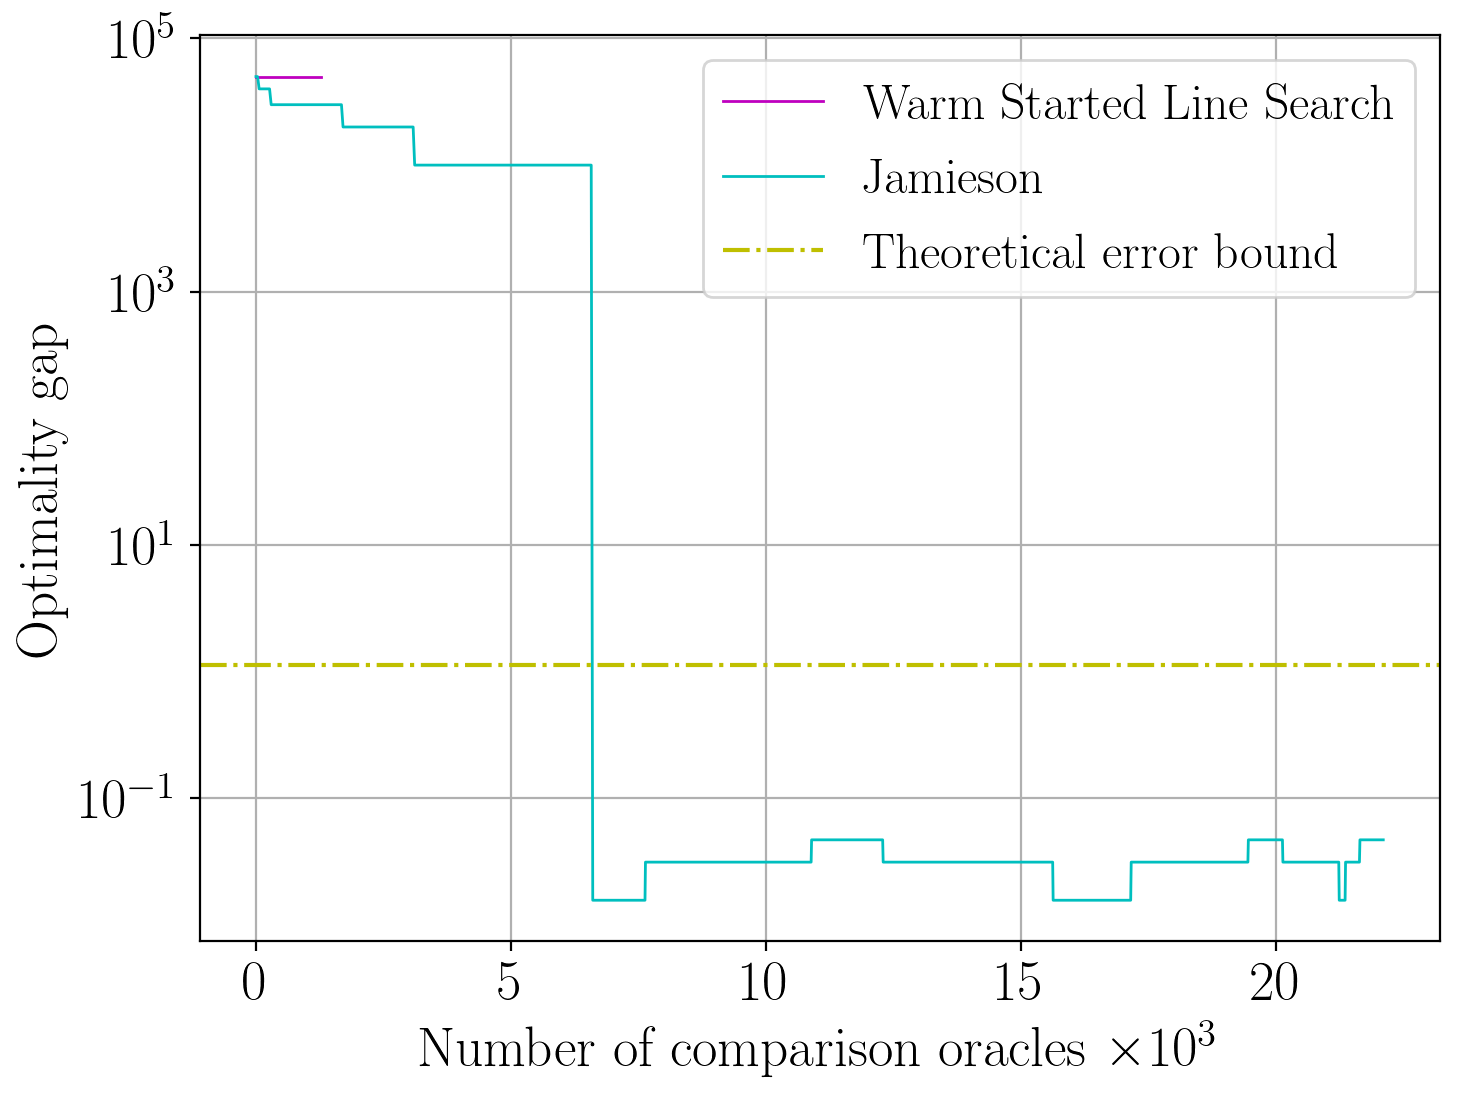

In [147]:

## Plot the results
x0 = 100*np.ones((d,1))
init_regret = object_fcn(x0)
#plot_iter = 1540
plot_iter = -1

plt.figure(figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE+2)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE-2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plt.plot( np.append([0],c_num_queries/1000)[0:num_iterations], np.append([init_regret],regret)[0:num_iterations],'b-', label='Fixed Step Size', linewidth=1)
#plt.plot( np.append([0],c_num_queries_linesearch/1000)[0:plot_iter], np.append([init_regret],regret_linesearch)[0:plot_iter],'g-', label='Line Search', linewidth=1)
plt.plot( np.append([0],c_num_queries_warm_started/1000)[0:plot_iter], np.append([init_regret],regret_warm_started)[0:plot_iter],'m-', label='Warm Started Line Search', linewidth=1)
plt.plot( np.append([0],c_num_queries_jamieson/1000)[0:plot_iter], np.append([init_regret],regret_jamieson)[0:plot_iter],'c-', label='Jamieson', linewidth=1)
plt.axhline(y=(9/8)*default_step_size, color='y', linestyle='-.',label='Theoretical error bound')
plt.xlabel(r'Number of comparison oracles $\times 10^3$')
plt.ylabel('Optimality gap')
plt.yscale('log')
#plt.ylim([10**(-1.55),10**(5.5)])
plt.legend(loc="upper right")
plt.grid(True)
#plt.savefig('quad_linesearch1.pdf')  
plt.show()


In [17]:
'''
## Plot the results
init_regret = object_fcn(x0)
plot_iter = 2000


fig, ax1 = plt.subplots(figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

color = 'tab:blue'
ax1.set_xlabel(r'Number of comparison oracles $\times 10^3$')
ax1.set_ylabel('Optimality gap', color=color)
ax1.set_yscale('log')
ax1.set_ylim([10**(-1.55),10**(5.5)])
plt.plot( np.append([0],c_num_queries/1000)[0:plot_iter], np.append([init_regret],regret)[0:plot_iter],'b-', label='Fixed Step Size', linewidth=1)
plt.axhline(y=1.5*default_step_size, color='y', linestyle='-.',label='Theoretical error bound')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Fraction flipped measurement', color=color)  # we already handled the x-label with ax1
plt.plot( np.append([0],c_num_queries/1000)[0:plot_iter],np.append([0],tau_vec)[0:plot_iter],'r-', label='Fixed Step Size', linewidth=0.4)
ax2.set_ylim([-0.025,0.575])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('quad_flip1.pdf')  
plt.show()
'''

'\n## Plot the results\ninit_regret = object_fcn(x0)\nplot_iter = 2000\n\n\nfig, ax1 = plt.subplots(figsize=(8, 6), dpi=200, facecolor=\'w\', edgecolor=\'k\')\n\ncolor = \'tab:blue\'\nax1.set_xlabel(r\'Number of comparison oracles $\times 10^3$\')\nax1.set_ylabel(\'Optimality gap\', color=color)\nax1.set_yscale(\'log\')\nax1.set_ylim([10**(-1.55),10**(5.5)])\nplt.plot( np.append([0],c_num_queries/1000)[0:plot_iter], np.append([init_regret],regret)[0:plot_iter],\'b-\', label=\'Fixed Step Size\', linewidth=1)\nplt.axhline(y=1.5*default_step_size, color=\'y\', linestyle=\'-.\',label=\'Theoretical error bound\')\nax1.tick_params(axis=\'y\', labelcolor=color)\n\nax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis\n\ncolor = \'tab:red\'\nax2.set_ylabel(\'Fraction flipped measurement\', color=color)  # we already handled the x-label with ax1\nplt.plot( np.append([0],c_num_queries/1000)[0:plot_iter],np.append([0],tau_vec)[0:plot_iter],\'r-\', label=\'Fixed Step Size\', l

convergence at approx 45k when m = 400
convergence at 50k when m =200
convergence at approx 68k when m = 80

In [18]:
'''
## Plot the results
init_regret = object_fcn(x0)
plot_iter = 100

plt.figure(figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
#plt.plot( np.append([0],c_num_queries)[0:num_iterations],np.log( np.append([init_regret],regret)[0:num_iterations]),'b-', label='Fixed Step Size', linewidth=1)
plt.plot( np.append([0],c_num_queries_linesearch/1000)[0:plot_iter], np.append([init_regret],regret_linesearch)[0:plot_iter],'g-', label='Line Search', linewidth=1)
plt.plot( np.append([0],c_num_queries_warm_started/1000)[0:plot_iter], np.append([init_regret],regret_warm_started)[0:plot_iter],'m-', label='Warm Started Line Search', linewidth=1)
plt.axhline(y=1.5*default_step_size, color='y', linestyle='-.',label='Theoretical error bound')
plt.xlabel(r'Number of comparison oracles $\times 10^3$')
plt.ylabel('Optimality gap')
plt.yscale('log')
plt.ylim([10**(-1.55),10**(5.5)])
plt.xlim([-1,26])
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('quad_linesearch1_zoom_in.pdf')  
plt.show()
'''

'\n## Plot the results\ninit_regret = object_fcn(x0)\nplot_iter = 100\n\nplt.figure(figsize=(8, 6), dpi=200, facecolor=\'w\', edgecolor=\'k\')\n#plt.plot( np.append([0],c_num_queries)[0:num_iterations],np.log( np.append([init_regret],regret)[0:num_iterations]),\'b-\', label=\'Fixed Step Size\', linewidth=1)\nplt.plot( np.append([0],c_num_queries_linesearch/1000)[0:plot_iter], np.append([init_regret],regret_linesearch)[0:plot_iter],\'g-\', label=\'Line Search\', linewidth=1)\nplt.plot( np.append([0],c_num_queries_warm_started/1000)[0:plot_iter], np.append([init_regret],regret_warm_started)[0:plot_iter],\'m-\', label=\'Warm Started Line Search\', linewidth=1)\nplt.axhline(y=1.5*default_step_size, color=\'y\', linestyle=\'-.\',label=\'Theoretical error bound\')\nplt.xlabel(r\'Number of comparison oracles $\times 10^3$\')\nplt.ylabel(\'Optimality gap\')\nplt.yscale(\'log\')\nplt.ylim([10**(-1.55),10**(5.5)])\nplt.xlim([-1,26])\nplt.legend(loc="upper right")\nplt.grid(True)\nplt.savefig(\'q